<h1>1. Naive Bayes </h1>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

## 1.1 Loading Data

In [2]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

import pandas
data = pandas.read_csv('preprocessed_data.csv')

In [3]:
## Gives us the shape of the data
data.shape     


(109248, 9)

In [4]:
# Creating the approved and rejected data frames

project_approved = data[data['project_is_approved'] == 1]
project_reject = data[data['project_is_approved'] == 0]

print('Number of projects that got approval : ', project_approved.shape)
print("Numer of projects that didn't get approval : ", project_reject.shape)

Number of projects that got approval :  (92706, 9)
Numer of projects that didn't get approval :  (16542, 9)


In [5]:
# Sampling 85000 points for approving (+ve) and 15000 points for not approving (-ve) points

# Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

project_approved = project_approved[project_approved['project_is_approved'] == 1].sample(n = 85000, random_state=1)
project_reject = project_reject[project_reject['project_is_approved'] == 0].sample(n = 15000, random_state=1)

# Reference: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# Concatinating the two data frames

# Reference: https://stackoverflow.com/questions/51835369/combine-two-dataframes-one-row-from-each-one-at-a-time-python-pandas
data = pd.concat([project_approved, project_reject]).sort_index(kind='merge')

In [6]:
data.shape

(100000, 9)

In [7]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [8]:
## Here we are dividing our data into two parts 1. Where our project is approved 2. Where our project is not approved
y = data['project_is_approved'].values
x = data.drop(['project_is_approved'], axis=1)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [9]:
# write your code in following steps for task 1
# 1. Split your data.
# 2. Perform Bag of Words Vectorization of text data.
# 3. Perform tfidf vectorization of text data.
# 4. perform one-hot encoding of categorical features.
# 5. perform normalization of numerical features
# 6. For set 1 stack up all the features using hstack()
# 7. For set 2 stack up all the features using hstack()
# 8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values, using a 2D line plot.
# 9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)
# 10. Plot confusion matrix based on the best threshold value
# 11. Either for the model in set 1 or in set 2, print the top 20 features(you have to print the names, not the indexes) associated with the positive and negative classes each.
# 12. Summarize your observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 
# 13. You can use Prettytable or any other tabular format for comparison.


# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

In [10]:
# Split the dataset 
# 1) If you want to apply simple cross-validation, split the dataset into 3 parts (ie., train, CV and test sets)
# 2) If you want to apply K-fold CV (or) GridSearch Cross Validation (or) Randomized Search Cross Validation, just split the dataset into 2 parts (ie., train and test sets)

## Use train test split to stratifically divide the data into two datasets - train , test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=42) # as we are using grid search we dont have to use cross validation set

In [11]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(67000, 8)
(33000, 8)
(67000,)
(33000,)


<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [12]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Title' (Optional)


In [13]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay'
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

## We will be doing BOW vectorization in two steps :
## 1. We will fit the data 
## 2. We will transform the data

## 1. Fitting the data : For fitting the data we will use count vectorizer which we have already imported
vectorizer_eassy_bow = CountVectorizer(min_df = 10)
vectorizer_eassy_bow.fit(x_train['essay'].values)

## 2. Transforming the data to its vectors form 
x_train_bow = vectorizer_eassy_bow.transform(x_train['essay'].values)
x_test_bow = vectorizer_eassy_bow.transform(x_test['essay'].values)

print("Shape of matrix after one hot encodig ",x_train_bow.shape , y_train.shape)
print("Shape of matrix after one hot encodig ",x_test_bow.shape , y_test.shape)

Shape of matrix after one hot encodig  (67000, 13793) (67000,)
Shape of matrix after one hot encodig  (33000, 13793) (33000,)


In [14]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
# Apply TF-IDF vectorization on 'Preprocessed_Title' (Optional)


In [15]:
# Apply TFIDF vectorization on 'Preprocessed_Essay'
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

## We will be doing TFIDF vectorization in two steps :
## 1. We will fit the data 
## 2. We will transform the data

## 1. Fitting the data : For fitting the data we will use count vectorizer which we have already imported
vectorizer_eassy_tfidf = TfidfVectorizer(min_df = 10)
vectorizer_eassy_tfidf.fit(x_train['essay'].values)

## 2. Transforming the data to its vectors form 
x_train_tfidf = vectorizer_eassy_tfidf.transform(x_train['essay'].values)
x_test_tfidf= vectorizer_eassy_tfidf.transform(x_test['essay'].values)

print("Shape of matrix after one hot encodig ",x_train_tfidf.shape , y_train.shape)
print("Shape of matrix after one hot encodig ",x_test_tfidf.shape , y_test.shape)

Shape of matrix after one hot encodig  (67000, 13793) (67000,)
Shape of matrix after one hot encodig  (33000, 13793) (33000,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [16]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# Apply Normalization on the numerical features using Normalizer().


### 1.4.1 - Performing Vectorization on Categrorica Data 

1.4.1.1 - School_State

In [17]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

## We will be doing vectorization in two steps :
## 1. We will fit the data 
## 2. We will transform the data



## 1. Fitting the data : For fitting the data we will use count vectorizer which we have already imported
vectorizer_school_state = CountVectorizer() 
vectorizer_school_state.fit(x_train['school_state'].values)
    
## 2. Transforming the data to its vectors form 
x_train_school_state = vectorizer_school_state.transform(x_train['school_state'].values)
x_test_school_state = vectorizer_school_state.transform(x_test['school_state'].values)

print("Shape of matrix after one hot encodig on Train Data",x_train_school_state.shape)
print("Shape of matrix after one hot encodig on Test Data",x_test_school_state.shape)

## Lets get the feature names present in school state https://stackoverflow.com/questions/42525072/get-selected-feature-names-tfidf-vectorizer#:~:text=You%20can%20use%20tfidf_vectorizer.,selected)%20from%20the%20raw%20documents.
print("Features Names are : ", vectorizer_school_state.get_feature_names())

Shape of matrix after one hot encodig on Train Data (67000, 51)
Shape of matrix after one hot encodig on Test Data (33000, 51)
Features Names are :  ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


1.4.1.2 -  Teacher Prefix

In [18]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

## We will be doing vectorization in two steps :
## 1. We will fit the data 
## 2. We will transform the data



## 1. Fitting the data : For fitting the data we will use count vectorizer which we have already imported
vectorizer_teacher_prefix = CountVectorizer() 
vectorizer_teacher_prefix.fit(x_train['teacher_prefix'].values)
    
## 2. Transforming the data to its vectors form 
x_train_teacher_prefix = vectorizer_teacher_prefix.transform(x_train['teacher_prefix'].values)
x_test_teacher_prefix = vectorizer_teacher_prefix.transform(x_test['teacher_prefix'].values)

print("Shape of matrix after one hot encodig on Train Data",x_train_teacher_prefix.shape)
print("Shape of matrix after one hot encodig on Test Data",x_test_teacher_prefix.shape)

## Lets get the feature names present in school state https://stackoverflow.com/questions/42525072/get-selected-feature-names-tfidf-vectorizer#:~:text=You%20can%20use%20tfidf_vectorizer.,selected)%20from%20the%20raw%20documents.
print("Features Names are : ", vectorizer_teacher_prefix.get_feature_names())

Shape of matrix after one hot encodig on Train Data (67000, 5)
Shape of matrix after one hot encodig on Test Data (33000, 5)
Features Names are :  ['dr', 'mr', 'mrs', 'ms', 'teacher']


1.4.1.3  clean categories  

In [19]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

## We will be doing vectorization in two steps :
## 1. We will fit the data 
## 2. We will transform the data



## 1. Fitting the data : For fitting the data we will use count vectorizer which we have already imported
vectorizer_clean_categories = CountVectorizer() 
vectorizer_clean_categories.fit(x_train['clean_categories'].values)
    
## 2. Transforming the data to its vectors form 
x_train_clean_categories = vectorizer_clean_categories.transform(x_train['clean_categories'].values)
x_test_clean_categories = vectorizer_clean_categories.transform(x_test['clean_categories'].values)

print("Shape of matrix after one hot encodig on Train Data",x_train_clean_categories.shape)
print("Shape of matrix after one hot encodig on Test Data",x_test_clean_categories.shape)

## Lets get the feature names present in school state https://stackoverflow.com/questions/42525072/get-selected-feature-names-tfidf-vectorizer#:~:text=You%20can%20use%20tfidf_vectorizer.,selected)%20from%20the%20raw%20documents.
print("Features Names are : ", vectorizer_clean_categories.get_feature_names())

Shape of matrix after one hot encodig on Train Data (67000, 9)
Shape of matrix after one hot encodig on Test Data (33000, 9)
Features Names are :  ['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


1.4.1.4 - Clean Sub Categories

In [20]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

## We will be doing vectorization in two steps :
## 1. We will fit the data 
## 2. We will transform the data



## 1. Fitting the data : For fitting the data we will use count vectorizer which we have already imported
vectorizer_clean_subcategories = CountVectorizer() 
vectorizer_clean_subcategories.fit(x_train['clean_subcategories'].values)
    
## 2. Transforming the data to its vectors form 
x_train_clean_subcategories = vectorizer_clean_subcategories.transform(x_train['clean_subcategories'].values)
x_test_clean_subcategories = vectorizer_clean_subcategories.transform(x_test['clean_subcategories'].values)

print("Shape of matrix after one hot encodig on Train Data",x_train_clean_subcategories.shape)
print("Shape of matrix after one hot encodig on Test Data",x_test_clean_subcategories.shape)
print('\n')
## Lets get the feature names present in school state https://stackoverflow.com/questions/42525072/get-selected-feature-names-tfidf-vectorizer#:~:text=You%20can%20use%20tfidf_vectorizer.,selected)%20from%20the%20raw%20documents.
print("Features Names are : ", vectorizer_clean_subcategories.get_feature_names())

Shape of matrix after one hot encodig on Train Data (67000, 30)
Shape of matrix after one hot encodig on Test Data (33000, 30)


Features Names are :  ['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


1.4.1.5 - project_grade_category 

In [21]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

## We will be doing vectorization in two steps :
## 1. We will fit the data 
## 2. We will transform the data



## 1. Fitting the data : For fitting the data we will use count vectorizer which we have already imported
vectorizer_project_grade_category = CountVectorizer() 
vectorizer_project_grade_category.fit(x_train['project_grade_category'].values)
    
## 2. Transforming the data to its vectors form 
x_train_project_grade_category = vectorizer_project_grade_category.transform(x_train['project_grade_category'].values)
x_test_project_grade_category = vectorizer_project_grade_category.transform(x_test['project_grade_category'].values)

print("Shape of matrix after one hot encodig on Train Data",x_train_project_grade_category.shape)
print("Shape of matrix after one hot encodig on Test Data",x_test_project_grade_category.shape)

## Lets get the feature names present in school state https://stackoverflow.com/questions/42525072/get-selected-feature-names-tfidf-vectorizer#:~:text=You%20can%20use%20tfidf_vectorizer.,selected)%20from%20the%20raw%20documents.
print("Features Names are : ", vectorizer_project_grade_category.get_feature_names())

Shape of matrix after one hot encodig on Train Data (67000, 4)
Shape of matrix after one hot encodig on Test Data (33000, 4)
Features Names are :  ['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


### 1.4.2- Performing Vectorization on Numerical Data 

1.4.2.1 - Price

In [22]:
# Apply Normalization on the numerical features using Normalizer().
## Using Normalization : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html

## We will be doing vectorization in two steps :
## 1. We will fit the data on train set
## 2. We will transform the data of train set
## 3. We will fit the data of test set
## 4. We will transform the data of test set



## 1. Fitting the data : For fitting the data we will use Normalizer which we have already imported
vectorizer_price = Normalizer() 
vectorizer_price.fit(x_train['price'].values.reshape(1,-1))

## 2. Transforming the data to its vectors form 
x_train_price  = vectorizer_price.transform(x_train['price'].values.reshape(1,-1))
x_train_price = x_train_price.reshape(-1,1)
print("Shape of matrix after Normalizing data on Train Data",x_train_price.shape)

## 3. Fitting the data : For fitting the data we will use Normalizer which we have already imported
vectorizer_price1 = Normalizer() 
vectorizer_price1.fit(x_test['price'].values.reshape(1,-1))

## 4. Transforming the data to its vectors form 
x_test_price  = vectorizer_price1.transform(x_test['price'].values.reshape(1,-1))
x_test_price = x_test_price.reshape(-1,1)
print("Shape of matrix after Normalizing data on Test Data",x_test_price.shape)


Shape of matrix after Normalizing data on Train Data (67000, 1)
Shape of matrix after Normalizing data on Test Data (33000, 1)


1.4.2.2 - teacher_number_of_previously_posted_projects

In [23]:
# Apply Normalization on the numerical features using Normalizer().
## Using Normalization : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html

## We will be doing vectorization in two steps :
## 1. We will fit the data on train set
## 2. We will transform the data of train set
## 3. We will fit the data of test set
## 4. We will transform the data of test set



## 1. Fitting the data : For fitting the data we will use Normalizer which we have already imported
vectorizer_teacher_number_of_previously_posted_projects = Normalizer() 
vectorizer_teacher_number_of_previously_posted_projects.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

## 2. Transforming the data to its vectors form 
x_train_teacher_number_of_previously_posted_projects  = vectorizer_price.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
x_train_teacher_number_of_previously_posted_projects = x_train_price.reshape(-1,1)
print("Shape of matrix after Normalizing data on Train Data",x_train_teacher_number_of_previously_posted_projects.shape)

## 3. Fitting the data : For fitting the data we will use Normalizer which we have already imported
vectorizer_teacher_number_of_previously_posted_projects1 = Normalizer() 
vectorizer_teacher_number_of_previously_posted_projects1.fit(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

## 4. Transforming the data to its vectors form 
x_test_teacher_number_of_previously_posted_projects  = vectorizer_teacher_number_of_previously_posted_projects1.transform(x_test['price'].values.reshape(1,-1))
x_test_teacher_number_of_previously_posted_projects = x_test_teacher_number_of_previously_posted_projects.reshape(-1,1)
print("Shape of matrix after Normalizing data on Test Data",x_test_teacher_number_of_previously_posted_projects.shape)


Shape of matrix after Normalizing data on Train Data (67000, 1)
Shape of matrix after Normalizing data on Test Data (33000, 1)


## Concatinating all features using hstack()



SET - 1

SET-1 : Categorical,numerical features + preprocessed_eassy(BOW)



In [24]:
# we can concat using : https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

x_train_concat = hstack((x_train_bow,x_train_school_state , x_train_teacher_prefix , x_train_clean_categories , x_train_clean_subcategories , x_train_project_grade_category , x_train_price , x_train_teacher_number_of_previously_posted_projects))
x_test_concat = hstack((x_test_bow,x_test_school_state , x_test_teacher_prefix , x_test_clean_categories , x_test_clean_subcategories , x_test_project_grade_category , x_test_price , x_test_teacher_number_of_previously_posted_projects))

print("Shape of Train and test after stacking ")
print(x_train_concat.shape)
print(x_test_concat.shape)


Shape of Train and test after stacking 
(67000, 13894)
(33000, 13894)



SET - 2

SET-2 : Categorical,numerical features + preprocessed_eassy(TFIDF)



In [25]:
# we can concat using : https://stackoverflow.com/a/19710648/4084039

from scipy.sparse import hstack

x_train_concat1 = hstack((x_train_tfidf,x_train_school_state , x_train_teacher_prefix , x_train_clean_categories , x_train_clean_subcategories , x_train_project_grade_category , x_train_price , x_train_teacher_number_of_previously_posted_projects))
x_test_concat1 = hstack((x_test_tfidf,x_test_school_state , x_test_teacher_prefix , x_test_clean_categories , x_test_clean_subcategories , x_test_project_grade_category , x_test_price , x_test_teacher_number_of_previously_posted_projects))

print("Shape of Train and test after stacking ")
print(x_train_concat1.shape)
print(x_test_concat1.shape)


Shape of Train and test after stacking 
(67000, 13894)
(33000, 13894)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### 1.5 Multinomial Naive Bayes using grid search cv (Set -1)

#### Set 1

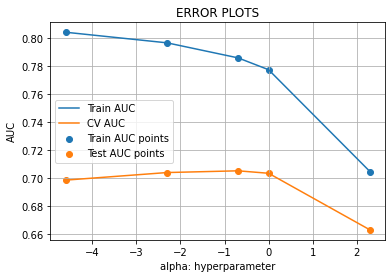

In [26]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

##Implementation :https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-naive-bayes


## importing MultinomialNB and GridSearch CV 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

##creating a class for Model 
multnomial_nb = MultinomialNB()

##specifying the parameters for GridSearch CV
params = {'alpha': [0.01 , 0.1 , 0.5 , 1.0 , 10.0]}
multinomial_nb_grid = GridSearchCV(multnomial_nb, param_grid = params , scoring='roc_auc' , cv = 10 , return_train_score = True)
multinomial_nb_grid.fit(x_train_concat , y_train)

# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

# Finding the best parameter using gridsearchcv and 10-folds
## Source : https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
multinomial_nb_grid = GridSearchCV(multnomial_nb, params, cv=10, scoring='roc_auc', return_train_score=True)
multinomial_nb_grid.fit(x_train_concat , y_train)


train_auc=  multinomial_nb_grid.cv_results_['mean_train_score']
train_auc_std= multinomial_nb_grid.cv_results_['std_train_score']
test_auc = multinomial_nb_grid.cv_results_['mean_test_score'] 
test_auc_std= multinomial_nb_grid.cv_results_['std_test_score']



# We use log(alpha) values so as to get a more distinguishable graph because log is monotonous function 
# and it won't affect our results

# plotting graph for auc score : https://stackoverflow.com/a/48803361/4084039
plt.plot(np.log(params['alpha']), train_auc, label='Train AUC')


# source : https://stackoverflow.com/a/48803361/4084039
plt.plot(np.log(params['alpha']), test_auc, label='CV AUC')


plt.scatter(np.log(params['alpha']), train_auc, label='Train AUC points')
plt.scatter(np.log(params['alpha']), test_auc , label='Test AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### In above code we are fitting 10 folds on 5 parameters total we get 50 fit

In [27]:
## Next step is printing best scores for train data , test data , Overall best score , Best parameter 
## https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-naive-bayes
train_accuracy = print('Train Accuracy : %.3f' %multinomial_nb_grid.best_estimator_.score(x_train_concat , y_train))
test_accuracy = print('Test Accuracy : %.3f' %multinomial_nb_grid.best_estimator_.score(x_test_concat , y_test))
best_accuracy = print('Best Accuracy through Grid Search  %.3f' %multinomial_nb_grid.best_score_)
best_alpha  = print('Best Parameters : ',multinomial_nb_grid.best_params_)




Train Accuracy : 0.774
Test Accuracy : 0.743
Best Accuracy through Grid Search  0.705
Best Parameters :  {'alpha': 0.5}


In [28]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.


In [29]:
# Here we are choosing the best_α based on GridSearchCV results
best_alpha  = print('Best Parameters : ',multinomial_nb_grid.best_params_)


Best Parameters :  {'alpha': 0.5}


In [30]:
best_alpha = 0.5

In [31]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.


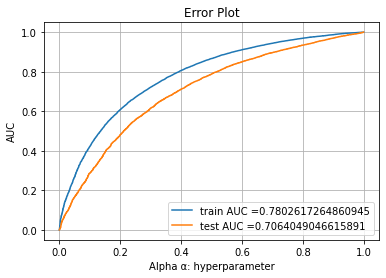

CPU times: user 402 ms, sys: 184 ms, total: 586 ms
Wall time: 377 ms


In [32]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB

# Creating the classifier
multnomial_nb = MultinomialNB(alpha= best_alpha)
multnomial_nb.fit(x_train_concat, y_train)


# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the predicted probability scores for test and train values
y_train_pred = multnomial_nb.predict_proba(x_train_concat)[:,1]   
y_test_pred = multnomial_nb.predict_proba(x_test_concat)[:,1]


train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha α: hyperparameter")
plt.ylabel("AUC")
plt.title("Error Plot")
plt.grid()
plt.show()

**We can finally observe that the curve for test AUC is lower then train AUC . 
We choose alpha value as 0.5 because it has maximum AUC value on Cross Validation set , also the AUC score for train data is aprroximately 0.78 and for test data is 0.70 .**

In [33]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.


In [34]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)

def find_best_probability(probability , threshold , fpr , tpr):
    ## we can find the threshold using the formula tpr(1-fpr)
    ## for threshold to be maximum we are using np.argmax function which yeilds the maximum value
    threshold = threshold[np.argmax(tpr*(1-fpr))]   
    print("Value of fpr(1-tpr) is " , threshold ,  "for threshold" , np.round(threshold,3))
    
    prediction = []
    for j in probability:
        if j>=threshold:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

from sklearn.metrics import classification_report

y_pred_new = multnomial_nb.predict(x_test_concat)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_new, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.29      0.50      0.37      4950
     class 1       0.90      0.79      0.84     28050

    accuracy                           0.74     33000
   macro avg       0.60      0.64      0.60     33000
weighted avg       0.81      0.74      0.77     33000



In [36]:
%%time
## lets find the accuracy , precission , recall and f1 score on test dataset
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = multnomial_nb.predict(x_test_concat)

test_accuracy = print(' Accuracy on test dataset: %.3f' %accuracy_score(y_test , y_pred_new))
test_Precision_score = print(' Precision  on test dataset: %.3f' %precision_score(y_test , y_pred_new))
test_f1_score = print(' F1 score on test dataset: %.3f' %f1_score(y_test , y_pred_new))
recall_score = print(' Recall score on test dataset: %.3f' %recall_score(y_test , y_pred_new))


 Accuracy on test dataset: 0.743
 Precision  on test dataset: 0.900
 F1 score on test dataset: 0.839
 Recall score on test dataset: 0.786
CPU times: user 79.7 ms, sys: 222 µs, total: 79.9 ms
Wall time: 77.5 ms


Confusion Matrix of Train Dataset: 
Value of fpr(1-tpr) is  0.8630739787404573 for threshold 0.863


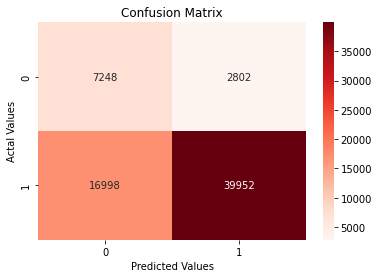

In [37]:
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
## https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn
from sklearn.metrics import confusion_matrix

print("Confusion Matrix of Train Dataset: ")

##print(confusion_matrix(y_train, find_best_probability(y_train_pred, train_thresholds, train_fpr, train_tpr)))

confusion_metric = metrics.confusion_matrix(y_train ,find_best_probability(y_train_pred, train_thresholds, train_fpr, train_tpr))
## For heat maphttps://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
## If annot is True data value is written inside each cell and cmao is used for colour coordination of the confusion matrix 
sns.heatmap(confusion_metric , annot=True , fmt='d' , cmap = 'Reds')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Confusion Matrix of Test Dataset: 
Value of fpr(1-tpr) is  0.905948871136255 for threshold 0.906


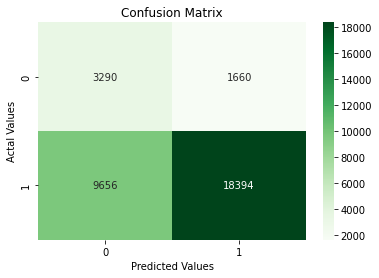

In [38]:
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

## https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn
from sklearn.metrics import confusion_matrix

print("Confusion Matrix of Test Dataset: ")

##print(confusion_matrix(y_train, find_best_probability(y_train_pred, train_thresholds, train_fpr, train_tpr)))

confusion_metric = metrics.confusion_matrix(y_test ,find_best_probability(y_test_pred, test_thresholds, test_fpr, test_tpr))
## Fir heat maphttps://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
## If annot is True data value is written inside each cell and cmao is used for colour coordination of the confusion matrix 
sns.heatmap(confusion_metric , annot=True , fmt='d' , cmap = 'Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

#### Set 2

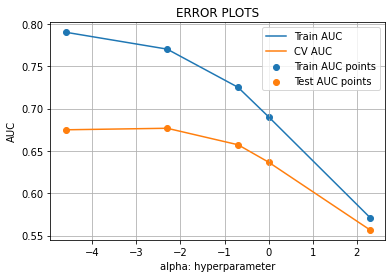

In [39]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

##Implementation :https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-naive-bayes


## importing MultinomialNB and GridSearch CV 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

##creating a class for Model 
multnomial_nb = MultinomialNB()

##specifying the parameters for GridSearch CV
params = {'alpha': [0.01 , 0.1 , 0.5 , 1.0 , 10.0]}
multinomial_nb_grid = GridSearchCV(multnomial_nb, param_grid = params , scoring='roc_auc' , cv = 10 , return_train_score = True)
multinomial_nb_grid.fit(x_train_concat1 , y_train)

# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

# Finding the best parameter using gridsearchcv and 10-folds
## Source : https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
multinomial_nb_grid = GridSearchCV(multnomial_nb, params, cv=10, scoring='roc_auc', return_train_score=True)
multinomial_nb_grid.fit(x_train_concat1 , y_train)


train_auc=  multinomial_nb_grid.cv_results_['mean_train_score']
train_auc_std= multinomial_nb_grid.cv_results_['std_train_score']
test_auc = multinomial_nb_grid.cv_results_['mean_test_score'] 
test_auc_std= multinomial_nb_grid.cv_results_['std_test_score']



# We use log(alpha) values so as to get a more distinguishable graph because log is monotonous function 
# and it won't affect our results

# plotting graph for auc score : https://stackoverflow.com/a/48803361/4084039
plt.plot(np.log(params['alpha']), train_auc, label='Train AUC')


# source : https://stackoverflow.com/a/48803361/4084039
plt.plot(np.log(params['alpha']), test_auc, label='CV AUC')


plt.scatter(np.log(params['alpha']), train_auc, label='Train AUC points')
plt.scatter(np.log(params['alpha']), test_auc , label='Test AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [40]:
## Next step is printing best scores for train data , test data , Overall best score , Best parameter 
## https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-naive-bayes
train_accuracy = print('Train Accuracy : %.3f' %multinomial_nb_grid.best_estimator_.score(x_train_concat , y_train))
test_accuracy = print('Test Accuracy : %.3f' %multinomial_nb_grid.best_estimator_.score(x_test_concat , y_test))
best_accuracy = print('Best Accuracy through Grid Search  %.3f' %multinomial_nb_grid.best_score_)
best_alpha  = print('Best Parameters : ',multinomial_nb_grid.best_params_)




Train Accuracy : 0.751
Test Accuracy : 0.721
Best Accuracy through Grid Search  0.677
Best Parameters :  {'alpha': 0.1}


In [41]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.


In [42]:
# Here we are choosing the best_α based on GridSearchCV results
best_alpha  = print('Best Parameters : ',multinomial_nb_grid.best_params_)


Best Parameters :  {'alpha': 0.1}


In [43]:
best_alpha = 0.1

In [44]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.


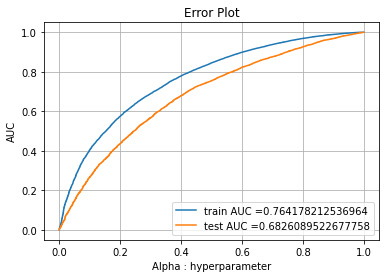

CPU times: user 1.09 s, sys: 185 ms, total: 1.28 s
Wall time: 1.07 s


In [45]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB

# Creating the classifier
multnomial_nb = MultinomialNB(alpha= best_alpha)
multnomial_nb.fit(x_train_concat1, y_train)


# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the predicted probability scores for test and train values
y_train_pred = multnomial_nb.predict_proba(x_train_concat1)[:,1]   
y_test_pred = multnomial_nb.predict_proba(x_test_concat1)[:,1]


train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("Error Plot")
plt.grid()
plt.show()

**Here we can see that the best alpha is 0.1 , train AUC is lower then test AUC and trai AUC gives a score of approximately 0.76 and test AUC gives a score of 0.68**

In [46]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.


In [47]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)

def find_best_probability(probability , threshold , fpr , tpr):
    ## we can find the threshold using the formula tpr(1-fpr)
    ## for threshold to be maximum we are using np.argmax function which yeilds the maximum value
    threshold = threshold[np.argmax(tpr*(1-fpr))]   
    print("Value of fpr(1-tpr) is " , threshold ,  "for threshold" , np.round(threshold,3))
    
    prediction = []
    for j in probability:
        if j>=threshold:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

In [48]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

from sklearn.metrics import classification_report

y_pred_new = multnomial_nb.predict(x_test_concat1)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_new, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.38      0.00      0.01      4950
     class 1       0.85      1.00      0.92     28050

    accuracy                           0.85     33000
   macro avg       0.61      0.50      0.46     33000
weighted avg       0.78      0.85      0.78     33000



In [49]:
%%time
## lets find the accuracy , precission , recall and f1 score on test dataset
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = multnomial_nb.predict(x_test_concat1)

test_accuracy = print(' Accuracy on test dataset: %.3f' %accuracy_score(y_test , y_pred_new))
test_Precision_score = print(' Precision  on test dataset: %.3f' %precision_score(y_test , y_pred_new))
test_f1_score = print(' F1 score on test dataset: %.3f' %f1_score(y_test , y_pred_new))
recall_score = print(' Recall score on test dataset: %.3f' %recall_score(y_test , y_pred_new))


 Accuracy on test dataset: 0.850
 Precision  on test dataset: 0.850
 F1 score on test dataset: 0.919
 Recall score on test dataset: 0.999
CPU times: user 213 ms, sys: 321 µs, total: 213 ms
Wall time: 211 ms


Confusion Matrix of Train Dataset: 
Value of fpr(1-tpr) is  0.8556585032189548 for threshold 0.856


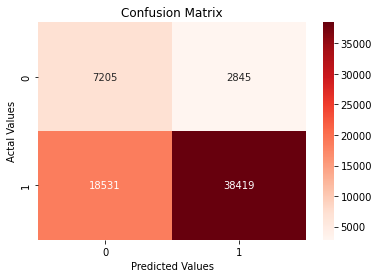

In [50]:
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
## https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn
from sklearn.metrics import confusion_matrix

print("Confusion Matrix of Train Dataset: ")

##print(confusion_matrix(y_train, find_best_probability(y_train_pred, train_thresholds, train_fpr, train_tpr)))

confusion_metric = metrics.confusion_matrix(y_train ,find_best_probability(y_train_pred, train_thresholds, train_fpr, train_tpr))
## For heat maphttps://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
## If annot is True data value is written inside each cell and cmao is used for colour coordination of the confusion matrix 
sns.heatmap(confusion_metric , annot=True , fmt='d' , cmap = 'Reds')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Confusion Matrix of Test Dataset: 
Value of fpr(1-tpr) is  0.8554437341919807 for threshold 0.855


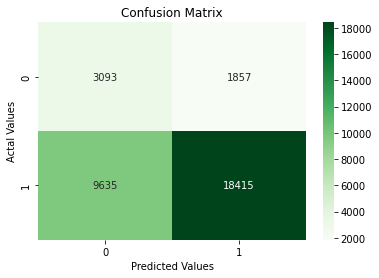

In [51]:
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
## https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn
from sklearn.metrics import confusion_matrix

print("Confusion Matrix of Test Dataset: ")

##print(confusion_matrix(y_train, find_best_probability(y_train_pred, train_thresholds, train_fpr, train_tpr)))

confusion_metric = metrics.confusion_matrix(y_test ,find_best_probability(y_test_pred, test_thresholds, test_fpr, test_tpr))
## Fir heat maphttps://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
## If annot is True data value is written inside each cell and cmao is used for colour coordination of the confusion matrix 
sns.heatmap(confusion_metric , annot=True , fmt='d' , cmap = 'Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [52]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)

## Top 20 important features of positive and negative class from<font color='red'> SET 1</font>


### Merging the categorical, numerical and text features names

In [53]:
# we can concat using : https://stackoverflow.com/a/19710648/4084039

from scipy.sparse import hstack

x_train_concat = hstack((x_train_bow,x_train_school_state , x_train_teacher_prefix , x_train_clean_categories , x_train_clean_subcategories , x_train_project_grade_category , x_train_price , x_train_teacher_number_of_previously_posted_projects))
x_test_concat = hstack((x_test_bow,x_test_school_state , x_test_teacher_prefix , x_test_clean_categories , x_test_clean_subcategories , x_test_project_grade_category , x_test_price , x_test_teacher_number_of_previously_posted_projects))

print("Shape of Train and test after stacking ")
print(x_train_concat.shape)
print(x_test_concat.shape)


Shape of Train and test after stacking 
(67000, 13894)
(33000, 13894)


In [54]:
## Creating a list of all the features all together 

features=[]    ## create a variable features where all the data of features will be stored in form of list  
for a in vectorizer_eassy_bow.get_feature_names() : ## This function returns all the features name in a perticular category in a form of list 
    features.append(a)    # adding the created list to the variable features
    
for a in vectorizer_school_state.get_feature_names() : ## This function returns all the features name in a perticular category in a form of list 
    features.append(a)    # adding the created list to the variable features
    
for a in vectorizer_teacher_prefix.get_feature_names() :   ## This function returns all the features name in a perticular category in a form of list 
    features.append(a)    # adding the created list to the variable features
    
for a in vectorizer_project_grade_category.get_feature_names() : ## This function returns all the features name in a perticular category in a form of list 
    features.append(a)    # adding the created list to the variable features

for a in vectorizer_clean_categories.get_feature_names() : ## This function returns all the features name in a perticular category in a form of list 
    features.append(a)   ## appends / add the object to end of the list , in our case we have lists of feature in a perticular category 
   
    
for a in vectorizer_clean_subcategories.get_feature_names() : ## This function returns all the features name in a perticular category in a form of list 
    features.append(a)   # adding the created list to the variable features
    
    
features.append("price")  ## As we know price is a numerical category which means we dont have to create a list of the feature name 
##instead we can directly add price to the variable features
features.append("teacher_number_of_previously_posted_projects")
len(features)

13894

## It can be observed that we have total of 13894 features features and now we have to find top 20 features amongst these 

In [55]:
#https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

##here we have created two classes 0 , 1 to find the probability for each class
class0 = multnomial_nb.feature_log_prob_[0, :].argsort()   # finding probability and making argsort for each class
class1 = multnomial_nb .feature_log_prob_[1, :].argsort()    



In [56]:
## Printing Top 20 features of both class 0 and class 1
 
print("Top 20 features of class 0 are :-")
print(np.take(features, class1[-20:])) # since argsort is asscending order

print("\n")

print("Top 20 features of class 1 are :-")
print(np.take(features, class1[-20:])) # since argsort is asscending order

Top 20 features of class 0 are :-
['financialliteracy' 'math_science' 'mr' 'visualarts' 'grades_3_5'
 'history_civics' 'other' 'students' 'grades_9_12' 'ca' 'teamsports'
 'health_lifescience' 'health_wellness' 'gym_fitness' 'specialneeds' 'ms'
 'care_hunger' 'warmth' 'appliedlearning' 'mrs']


Top 20 features of class 1 are :-
['financialliteracy' 'math_science' 'mr' 'visualarts' 'grades_3_5'
 'history_civics' 'other' 'students' 'grades_9_12' 'ca' 'teamsports'
 'health_lifescience' 'health_wellness' 'gym_fitness' 'specialneeds' 'ms'
 'care_hunger' 'warmth' 'appliedlearning' 'mrs']


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [57]:
#Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.
# Reference Link for Pretty table:  https://pypi.org/project/prettytable/

## Pretty Table 

In [58]:
## To create pretty table https://zetcode.com/python/prettytable/

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer","SET" ,"Model", " Best hyper parsmeter(best value of α)", "train-AUC" ,"test-AUC"]

x.add_row(["BOW","Set 1", "Naive Bayes", 'α=0.5' , 0.780 , 0.706])
x.add_row(["TFIDF","Set 2" ,"Naive Bayes", 'α=0.1', 0.764 , 0.682])

print(x)

+------------+-------+-------------+----------------------------------------+-----------+----------+
| Vectorizer |  SET  |    Model    |  Best hyper parsmeter(best value of α) | train-AUC | test-AUC |
+------------+-------+-------------+----------------------------------------+-----------+----------+
|    BOW     | Set 1 | Naive Bayes |                 α=0.5                  |    0.78   |  0.706   |
|   TFIDF    | Set 2 | Naive Bayes |                 α=0.1                  |   0.764   |  0.682   |
+------------+-------+-------------+----------------------------------------+-----------+----------+


1. We can  AUC score for BOW vectorizer is slightly high then  TFIDF vectorizer


2. Hyperparameter value for BOW vectorizer is 0.5 whereas for TFIDF is 0.1


3. Naive Bayes has better time and space complexity as compared to KNN


4. Although we sampaled our data but we can use Naive Bayes for large data also 


5. When it comes to accuracy scores we can see :
    
  **For BOW Vectorization**
  
    Train Accuracy : 0.774
    
    Test Accuracy : 0.743
    
    Best Accuracy through Grid Search  0.705
    
    Best Parameters :  {'alpha': 0.5}
    
   **For TFIDF vectorization**
   
    Train Accuracy : 0.751
    
    Test Accuracy : 0.721
    
    Best Accuracy through Grid Search  0.677
    
    Best Parameters :  {'alpha': 0.1}
        
   ***We can see BOW vectorization has slightly high train and test     accuracy values as compared to TFIDF vectorization***
    
    
6. Accuracy precision , recall values for BOW vectorizer and TFIDF vectorizer :
    
  **For BOW vectorizer**
  
    Accuracy on test dataset: 0.743
    
    Precision  on test dataset: 0.900
    
    F1 score on test dataset: 0.839
    
    Recall score on test dataset: 0.786
       
   **For TFIDF vectorizer**
   
    Accuracy on test dataset: 0.850
    
    Precision  on test dataset: 0.850
    
    F1 score on test dataset: 0.919
    
    Recall score on test dataset: 0.999
  
 ***Here we can see Accuracy precision , recall and f1 score of TFIDF vectorizer is more then that of BOW vectorizer***